# Initial value problem

In this chapter we will use the forward and backward finite difference formulae to solve the initial value problem. The accuracy and stability of the techniques will be briefly discussed.

## Problem definition

We now consider a general class of problem, which has the following form:

```{math}
:label: ivp1
\frac{\mathrm{d}y}{\mathrm{d}x}=f(x,y), \quad y(x_0)=y_0.
```

This type of first order differential equation is known as an *initial value problem*, because the solution for $y$ is determined from the derivative rule together with a known initial value $y(x_0)$. The special case where the function $f$ does not depend on $y$ is called the *autonomous* case.

We will tackle these problems by replacing the derivative terms using finite difference formulae. This results in a system of algebraic difference equations that either can be directly rearranged or solved using root-finding techniques. Schemes based on the forward and backward difference formulae are given below, with some discussion of their stability properties. Some further formulae will be outlined in the (optional) chapter on multi-stage methods.

The `numpy`, `scipy` and `matlplotlib` libraries need to be imported to run the code in this chapter.

In [1]:
#Import libraries that will be needed in this section
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

```{admonition} Numeric integration
:class: theorem
The use of geometric integral approximation formulae such as the left-hand rectangle rule, mid-point rectangle rule or Simpson’s rule can also be used to numerically integrate autonomous IVPs. Such techniques are equivalent to using finite difference formulae and the geometric arguments can help to motivate the methods. However, Taylor’s theorem is required to quantify the size of the analytic error in each case, and the theory of finite differences can be more readily generalised to a wider class of problems.
```

### Example case

In the sections below the technique will be demonstrated for the following initial value problem:

```{math}
:label: sampleprob
\frac{\mathrm{d}y}{\mathrm{d}x}=-y+(\cos(x)+2)y^2, \quad y(0)=0.4, \quad x\in[0,4]
```

We will compare our results to the analytic solution, which can be found by hand for this case. The solution is given by

\begin{equation}y=\frac{2}{4+\cos(x)-\sin(x)}.\end{equation}

In our finite difference approach we will use $n=1001$ array values, which corresponds to a step size $h=0.004$ on the range $[0,4]$. The values are generated using the `linspace` function from the `numpy` package, as shown in the code below. A plotter function will be used to graphically compare the analytic and numerical solutions.

In [2]:
f = lambda x,y: -y+(np.cos(x)+2)*y**2          #set up the lambda function
x=np.linspace(0,4,1001)                        #generate array of x values
yexact=2/(4+np.cos(x)-np.sin(x))               #exact solution
print('h=',x[1]-x[0])

h= 0.004


In [3]:
#plotter function to compare analytic and numerical solutions
def myplotter(x,y,yexact,funstr):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.tight_layout(pad=5.0) #increase subplot spacing
  fig.suptitle('Estimated integral of' + funstr)
  ax1.plot(x, y)
  ax2.plot(x,abs(y-yexact))
  ax1.set(xlabel='$x$',ylabel='Estimate')
  ax2.set(xlabel='$x$',ylabel='Error')
  print('Maximum error:', max(abs(y-yexact)))
  plt.show()
  return

## Explicit Euler scheme

From the forward difference formula {eq}`forwards1`

$$y_{k+1}= y_k+y^{\prime}(x_k)h+\mathcal{O}(h^2)$$

Substituting for $y^{\prime}(x_k)$ from the initial value problem {eq}`ivp1` leads to the following iterative formula, which is known as the explicit Euler method:

\begin{equation}y_{k+1}\simeq y_k + h f(x_k).\end{equation}

The formula uses the known value $(x_k,y_k)$ together with the known slope at that point to project forward to the next point. The calculation is then repeated at the new point, and in this manner we keep stepping forward until we reach the end of the integration domain. We start at the given initial value $(x_0,y_0)$.

A graphical illustration is provided below, demonstrating how each forward step takes us in tangent to one of the family of general solution curves. The approximation would be better for smaller step size!

<br>

```{image} images/forward1.png
:alt: forward stepping
:scale: 40%
:align: center
```

<br>

An example of how the method can be implemented is given in the function code below. In the definition it is assumed that:
* `f` is a lambda function for $f(x,y)$
* `x` is the array of (equally-spaced) $x$ values at which the solution is wanted
* `y0` is the initial value $y(x_0)$

In [4]:
def my_eulr(f,x,y0):

  n,h=len(x),x[1]-x[0]    #get number of values and step size
  y=np.zeros(len(x))      #form output y array
  y[0]=y0

  for k in range(n-1):
      x1,y1=x[k],y[k]     #labels introduced for convenience
      y2=y1+h*f(x1,y1)    #Euler forward difference
      y[k+1]=y2
  return y

### Example case

A solution to the sample problem {eq}`sampleprob` that uses `my_eulr` is given below. The plots are generated with the custom `myplotter` function.

Maximum error: 0.008406536436797118


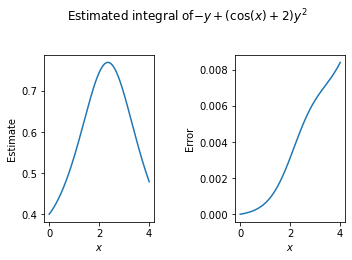

In [5]:
y=my_eulr(f,x,0.4)
myplotter(x,y,yexact,'$-y+(\cos(x)+2)y^2$')

<br>

## Implicit Euler scheme

From the backward difference formula {eq}`backwards1`

$$y_{k+1}= y_{k}+y^{\prime}(x_{k+1})h+\mathcal{O}(h^2)$$

Substituting for $y^{\prime}(x_{k+1})$ from the initial value problem {eq}`ivp1` leads to the following iterative formula, which is known as the implicit Euler method

\begin{equation}y_{k+1}\simeq y_k+h f(x_{k+1},y_{k+1})\end{equation}

Here, things begin to get a bit more complicated, since the expression for $y_{k+1}$ is given implicitly. Usually it is not possible to rearrange the expression to obtain $y_{k+1}$ explicitly, so a root-finding algorithm is required, such as the Newton-Raphson technique or a bisection or fixed point algorithm. An example implementation is shown in the code below, using `fsolve` from the `scipy` library. To use this root finding function, we need to write the implicit Euler formula in the form $F(x_k,x_{k+1},y_k,y_{k+1})= 0$, which gives

\begin{equation}F= y_{k+1}-y_k-hf(x_{k+1},y_{k+1}).\end{equation}

In [6]:

def my_eulri(f,x,y0):

  n,h=len(x),x[1]-x[0]    #get number of values and step size
  y=np.zeros(len(x))      #form output y array
  y[0]=y0

  for k in range(n-1):
      x1,y1=x[k],y[k]     #labels introduced for convenience
      x2=x1+h             #this is the same as x[k+1]

      F = lambda y2: (y2-y1-h*f(x2, y2)) #F(x1,x2,y1,y2)=0
      y2=fsolve(F,y1)                    #Solve backward difference
      y[k+1]=y2       
  return y

### Example case

A solution to the sample problem {eq}`sampleprob` that uses `my_eulri` is given below. The plots are generated with the custom `myplotter` function.

Maximum error: 0.008960470953344346


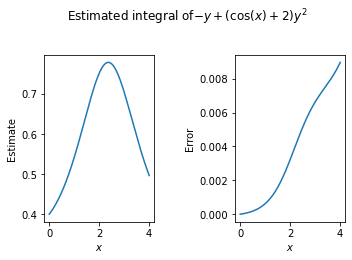

In [7]:
y=my_eulri(f,x,0.4)
myplotter(x,y,yexact,'$-y+(\cos(x)+2)y^2$')

### Fixed point techniques

As an alternative to using Newton-Raphson algorithm to find the root of an algebraic relationship, we can use a fixed-point iteration technique, designed for problems of the form

\begin{equation}x=F(x).\end{equation}

Such techniques are an important numerical analysis tool, and we will use them more when we study applications to partial differential equations. The approach proceeds by taking an initial guess $x=x_{guess}$ and substituting it into the right hand side of the equation.

* If $|x_{guess}-F(x_{guess})|$ is less than some specified tolerance then we conclude that our guess is a good approximation to the root.

* If the tolerance goal is not met, we use the result $F(x_{guess})$ as a new guess, and repeat the process.


```{exercise}
Write your own fixed point iteration code to find a root of $x=\cos(x)$, with an initial guess of $x=0.2$, with a tolerance of $10^{-7}$. Compare your result to the value given by `fsolve`.
```

In [8]:
# Initial guess
xguess= 0.2
tol = 10**(-7)
f = lambda x: np.cos(x)

while 1:
    x = f(xguess)
    if np.abs(x-xguess)<tol:
        break
    else:
        xguess = x

print('FP root: {:.8f}'.format(x))

xx = fsolve(lambda x: (x-np.cos(x)), 0.2,xtol=1e-7)
print('NR root: {:.8f}'.format(xx[0]))

FP root: 0.73908517
NR root: 0.73908513


## Accuracy

The truncation error in the explicit Euler method is $\mathcal{O}(h^2)$. It is the size of error introduced at each step, so it may also be known as the **local error**.

As we are integrating over $1/h$ steps, we expect that by the time we reach the end of the integration domain the **global error** may be $\mathcal{O}(h)$. This heuristic description is fairly accurate. However, the detailed picture is a little more complicated, as for some problems the local errors are amplified/compounded in subsequent steps, whilst in other problems the errors are damped out.

```{admonition} Discretisation tip
:class: tip
If you want to compute the step size $h$ that will discretise a domain with the right-hand end point included, it is useful to recognise that the $x$ values in the grid are in arithmetic progression. If the first term is $a$, then the last term is $a+(n-1)h$, where $n$ is the number of points. This gives the following result for an interval $[a,b]$

\begin{equation*}a+(n-1)h=b \quad \Rightarrow\quad h=\frac{b-a}{n-1}\end{equation*}
```

## Stability
The implicit Euler algorithm typically requires a root-solving algorithm (expensive) and it only offers the same order accuracy as the explicit Euler algorithm, since the error goes like $h$ in each case… So why do we need it? We will consider an illustrative example, provided by the problem

\begin{equation}\frac{\mathrm{d}y}{\mathrm{d}x}=-5y, \quad y(0)=2, \quad y\in[0,10]\end{equation}

First, let us demonstrate the solutions obtained for step size $h=0.41$, using each algorithm. Since we are given a step size rather than the number of $x$ values, we use the `arange` function from the `numpy` library to generate the array. In each plot, the numeric estimate is shown in blue and the analytic solution is shown in red.

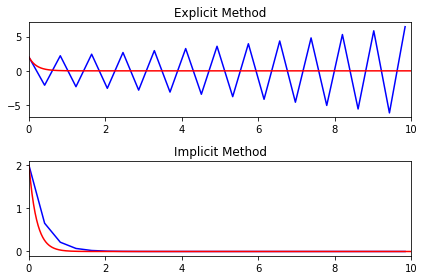

In [9]:

h = 0.41
x=np.arange(0,10,h)
f = lambda x,y: -5*y
ye = my_eulr(f,x,2)
yi = my_eulri(f,x,2)

xsol = np.linspace(0,10,1001)
ysol = 2*np.exp(-5*xsol)

fig,ax = plt.subplots(2,1)
ax[0].plot(x,ye,'b',xsol,ysol,'r')
ax[0].set_title('Explicit Method')
ax[0].set_xlim(0,10)
ax[1].plot(x, yi, 'b', xsol, ysol, 'r')
ax[1].set_title('Implicit Method')
ax[1].set_xlim(0,10)
fig.tight_layout()
plt.show()

Both the explicit and implicit Euler solutions have the same level of accuracy over a single step. However, in this example the errors in the explicit solution are amplified, whilst in the implicit solution they are damped. The implicit method is more stable for this example.

This example can be fully analysed by hand. Since it is linear, a root finding method is not needed to implement the backward formula. We can simply rearrange to obtain an explicit solution for $y_k$. In both cases, the resulting expression for $y_{k+1}$ can be applied recursively to obtain a closed form discrete solution in terms of the step size $h$ and the initial condition $y_0$. The details for each method are shown below.

The **explicit formula** gives

$$\displaystyle y_{k+1}= (1-5h)y_k \quad \Rightarrow \quad y_{k+1}=(1-5h)^{k+1}y_0, \qquad x=kh$$

The **implicit formula** gives

$$\displaystyle y_{k+1}=\frac{y_k}{1+5h} \quad \Rightarrow \quad y_{k+1}=\frac{y_0}{(1+5h)^{k+1}}, \qquad x=kh$$

Since $\displaystyle \lim_{h\rightarrow 0}(1\pm 5 h)^{x/h} = e^{\pm 5x}$, both results converge to the analytic solution $y=2e^{-5x}$ in the limit of small step sizes. However, the explicit Euler method displays oscillating growth for $|1-5h|>1$  (i.e. for $h>2/5$).

In general, explicit algorithms tend to be easier to implement than implicit algorithms, and are less computationally demanding for a given step size. However, for (dynamically) stable ODEs with a fast decaying or highly oscillatory mode, the explicit Euler method demands small step sizes. These types of ODE are called "stiff". For these problems, implicit methods tend to be better due to their generally superior stability. Amongst the implicit methods, the implicit implicit Euler method is particularly stable.

```{admonition} How is stability assessed in practical problems?
:class: theorem

Comparison of the local and global errors can give us an indication of the stability properties of the algorithm. The local errors generally ought to remain proportional to the size of the neglected terms in the truncated expansion. If these errors are growing then the algorithm is not stable.

The size of the error at each step depends on the method used and also the problem being solved. In particular, it depends on how large the gradient is. To account for this, and to produce a reliable result within specified error tolerances, many algorithms use adaptive step size methods, in which the error is estimated at each step by comparing the results from algorithms with different numbers of stages. The step size can then be decreased in regions where the tolerance would be exceeded. The `scipy` package offers a built-in algorithm that does exactly this, called integrate.solve_ivp
```

## Trapezoidal rule

Taking the average of the forward and backward difference formulae gives

```{math}
:label: trapz
y_{k+1}=y_k+\frac{h}{2}\biggr[f(x_k,y_k)+f(x_{k+1},y_{k+1})\biggr]
```

This result is equivalent to approximating the integral using the trapezium rule. It can be shown that the global error in this formula is $\mathcal{O}(h^2)$, whilst the global errors in the explicit and implicit Euler methods are both $\mathcal{O}(h)$.

The trapezoidal rule is also an implicit rule. It can be implemented using a minimal modification of the backward difference algorithm outlined above.  The implicit Euler method is more stable than the trapezoidal method.